In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
from src.graph import GraphModel 
import src.estimator as estimator
import src.utils as utils

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from IPython.display import display
from pyvis.network import Network

import pickle
import os

np.random.seed(42)

In [2]:
path = '../data/connectomes/'
connectomes = os.listdir(path)
connectomes

['rattus.norvegicus_brain_1.graphml',
 'rhesus_brain_1.graphml',
 'mouse_brain_1.graphml']

In [3]:
nx.read_graphml

<function networkx.readwrite.graphml.read_graphml(path, node_type=<class 'str'>, edge_key_type=<class 'int'>, force_multigraph=False, *, backend=None, **backend_kwargs)>

# Mouse Brain

In [4]:
extension = 'graphml'
name = 'mouse_brain_1'
file_path = f'{path}{name}.{extension}'
print(file_path)
connectome = nx.read_graphml(file_path)
g = nx.adjacency_matrix(connectome).A
g.shape[0]
s = GraphModel.calculate_spectrum(g)

../data/connectomes/mouse_brain_1.graphml


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_34087/4171854464.py:6: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.14.0. Use `.toarray()` instead.
  g = nx.adjacency_matrix(connectome).A


In [5]:
est = estimator.LogitRegEstimator2(g)
params, pvalues = est.estimate_parameters()
sigma, alpha, beta = params

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                22731
Model:                          Logit   Df Residuals:                    22728
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Apr 2024   Pseudo R-squ.:                  0.1221
Time:                        14:33:12   Log-Likelihood:                -11934.
converged:                       True   LL-Null:                       -13594.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.7895      0.147    -46.315      0.000      -7.077      -6.502
x1             0.0261      0.001     39.019      0.000       0.025       0.027
x2             0.0255      0.001     40.154      0.0

In [6]:
n = g.shape[0]
p = 0

alpha = alpha   #  negative 0.003
beta  = beta    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = sigma    # intercept the higher the harder for creating edges 6

threshold   = 0.5
n_iteration = 50
warm_up     = 30

params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [7]:
graph = GraphModel(**params_dict)
graphs, spec = graph.populate_edges( warm_up = warm_up, max_iterations = n_iteration, degree_dist_threshold=0.5, stability_window=5)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
KS Statistic: 0.028169014084507043
KS Statistic: 0.07981220657276995
KS Statistic: 0.06103286384976526
KS Statistic: 0.014084507042253521
Degree Distribution Stable: True
Graph Converged: True






/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


In [8]:
g_est = graphs[-1]
s_est = spec[-1]

## Visualizations

In [9]:
ut = utils.GraphUtils()

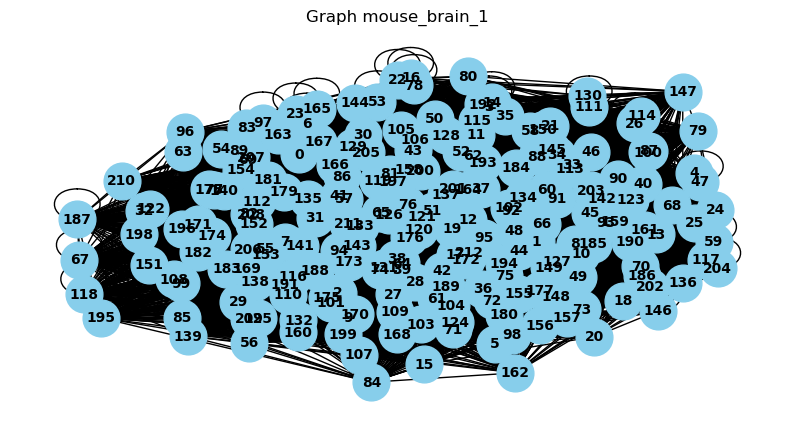

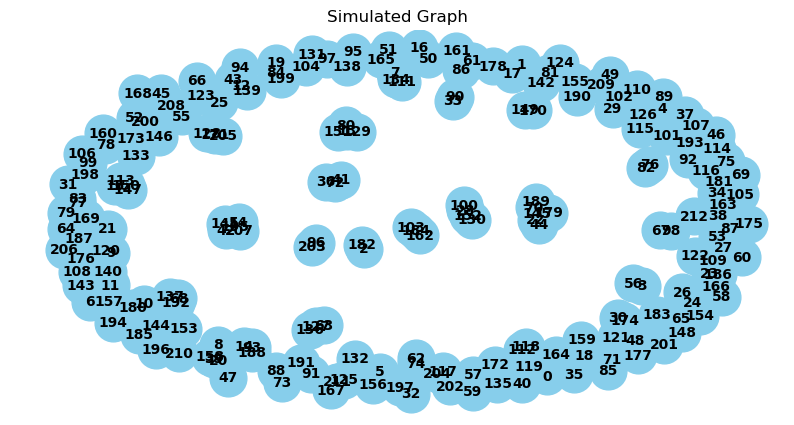

In [10]:
fig = ut.plot_graph_from_adjacency(g, pos=None, title='Graph ' + name, size=(10,5))
fig_est = ut.plot_graph_from_adjacency(g_est, pos=None, title = 'Simulated Graph', size=(10,5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


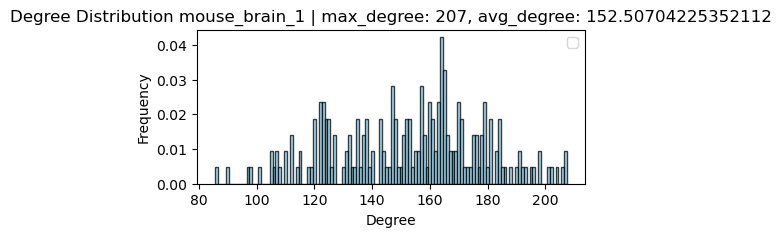

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


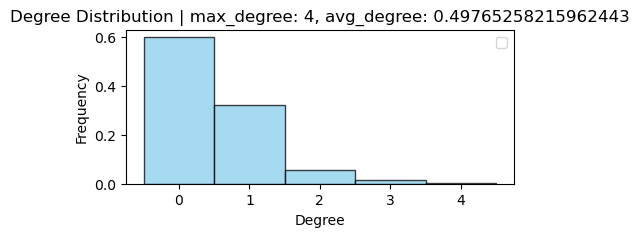

In [11]:
fig = ut.plot_degree_distribution(g, title='Degree Distribution '+name, size=(5,2))
fig_est = ut.plot_degree_distribution(g_est, title='Degree Distribution', size=(5,2))

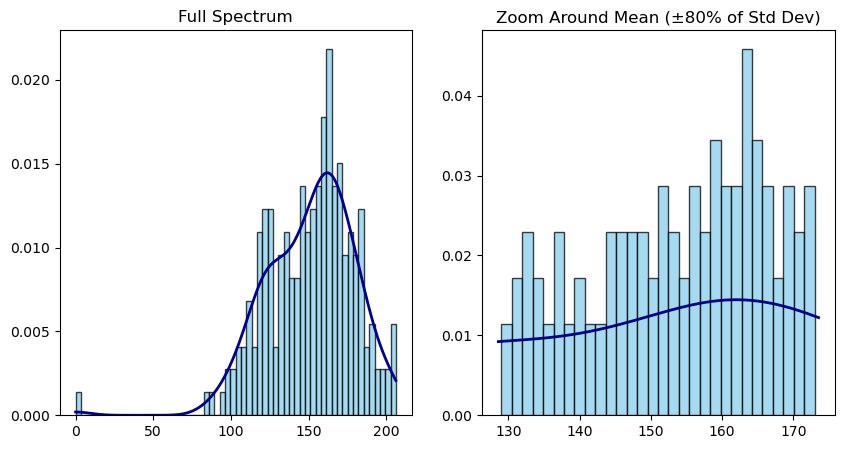

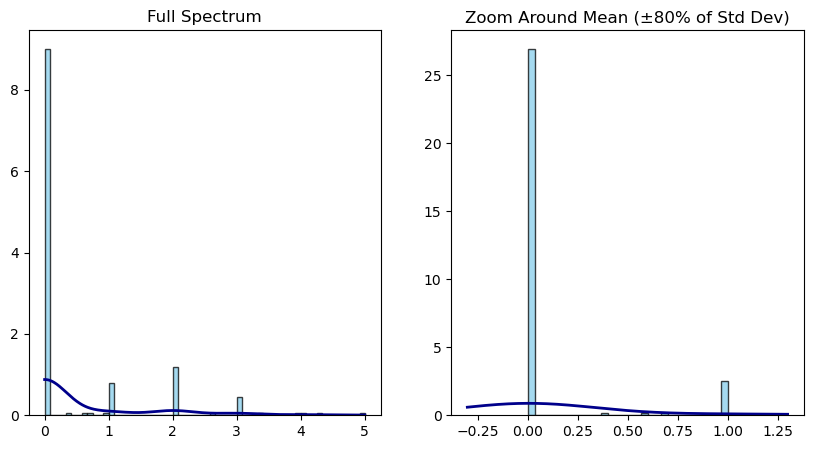

In [12]:
graph_model = GraphModel
s = graph_model.calculate_spectrum(g)
fig = ut.plot_spectrum_and_zoom(s, zoom_scale=0.8, size=(10,5))
fig_est = ut.plot_spectrum_and_zoom(s_est, zoom_scale=0.8, size=(10,5))

## Model Selection

In [13]:
import src.model_selection as ms 

real_graph = nx.from_numpy_array(g)
logit_graph = nx.from_numpy_array(g_est)

selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f'for: {name}')
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


for: mouse_brain_1
The best model is: WS
Model scores:
ER: 5.638589984646645
WS: 4.803554475292486
BA: 6.310748372176409
LG: 12.191266933109734


# Rhesus Brain

In [14]:
extension = 'graphml'
name = 'rhesus_brain_1'
file_path = f'{path}{name}.{extension}'
print(file_path)
connectome = nx.read_graphml(file_path)
g = nx.adjacency_matrix(connectome).A
g.shape[0]
s = GraphModel.calculate_spectrum(g)

../data/connectomes/rhesus_brain_1.graphml


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_34087/3919072262.py:6: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.14.0. Use `.toarray()` instead.
  g = nx.adjacency_matrix(connectome).A


In [15]:
est = estimator.LogitRegEstimator2(g)
params, pvalues = est.estimate_parameters()
sigma, alpha, beta = params

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                29161
Model:                          Logit   Df Residuals:                    29158
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Apr 2024   Pseudo R-squ.:                  0.1695
Time:                        14:34:02   Log-Likelihood:                -8122.0
converged:                       True   LL-Null:                       -9779.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6422      0.058    -79.904      0.000      -4.756      -4.528
x1             0.0443      0.001     45.044      0.000       0.042       0.046
x2             0.0364      0.001     34.017      0.0

In [16]:
n = g.shape[0]
p = 0

alpha = alpha   #  negative 0.003
beta  = beta    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = sigma    # intercept the higher the harder for creating edges 6

threshold   = 0.5
n_iteration = 50
warm_up     = 30

params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [17]:
graph = GraphModel(**params_dict)
graphs, spec = graph.populate_edges( warm_up = warm_up, max_iterations = n_iteration, degree_dist_threshold=0.5, stability_window=5)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
KS Statistic: 0.07024793388429752
KS Statistic: 0.05785123966942149
KS Statistic: 0.10330578512396695
KS Statistic: 0.045454545454545456
Degree Distribution Stable: True
Graph Converged: True






In [18]:
g_est = graphs[-1]
s_est = spec[-1]

## Visualizations

In [19]:
ut = utils.GraphUtils()

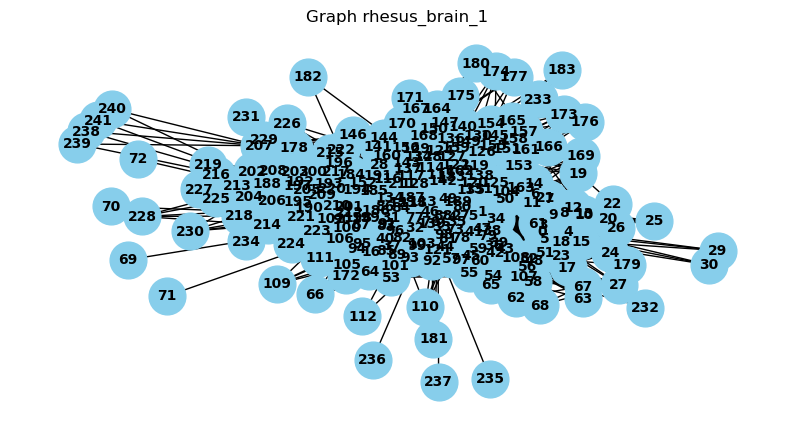

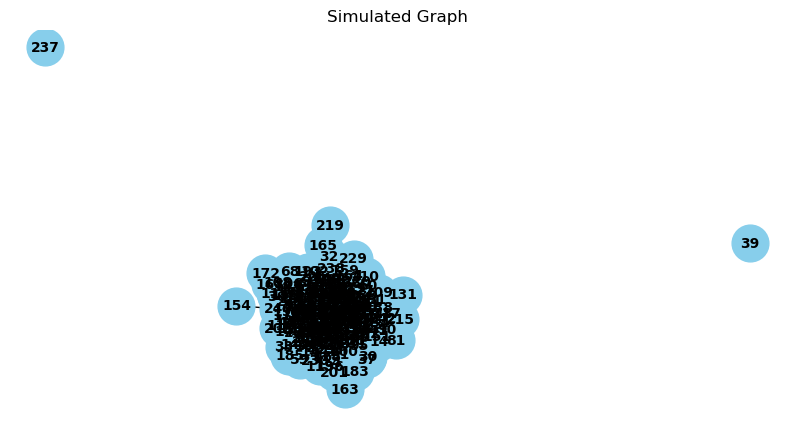

In [20]:
fig = ut.plot_graph_from_adjacency(g, pos=None, title='Graph ' + name, size=(10,5))
fig_est = ut.plot_graph_from_adjacency(g_est, pos=None, title = 'Simulated Graph', size=(10,5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


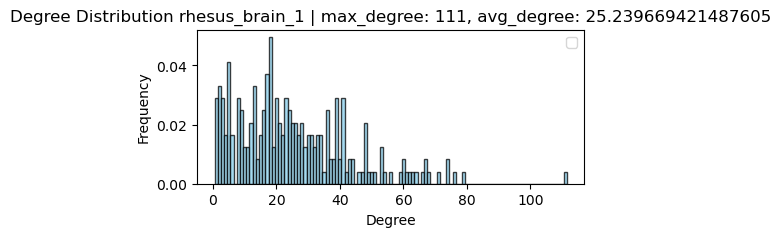

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


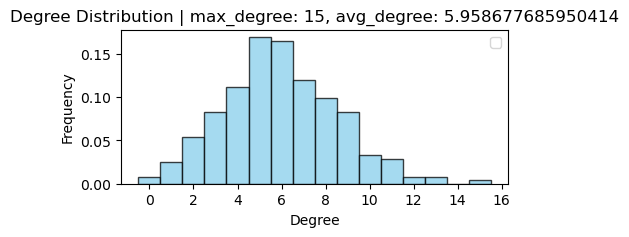

In [21]:
fig = ut.plot_degree_distribution(g, title='Degree Distribution '+name, size=(5,2))
fig_est = ut.plot_degree_distribution(g_est, title='Degree Distribution', size=(5,2))

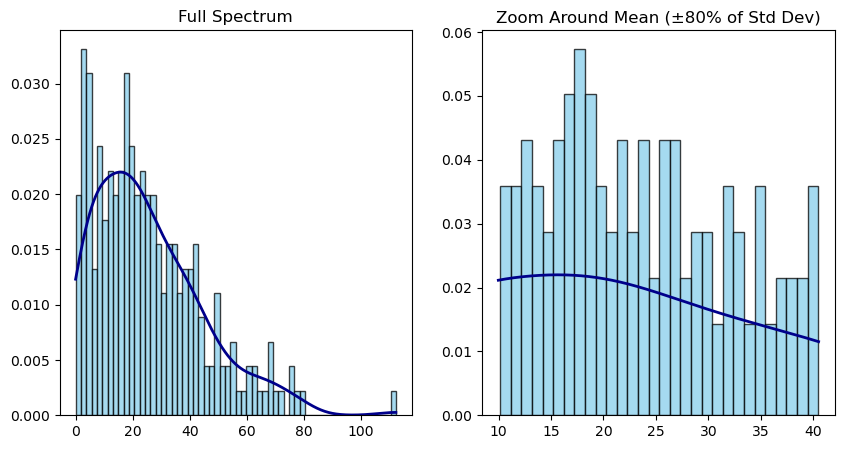

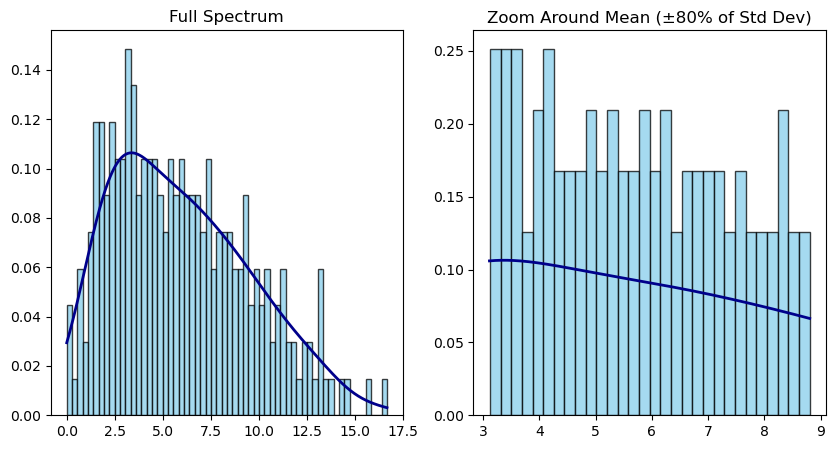

In [22]:
graph_model = GraphModel
s = graph_model.calculate_spectrum(g)
fig = ut.plot_spectrum_and_zoom(s, zoom_scale=0.8, size=(10,5))
fig_est = ut.plot_spectrum_and_zoom(s_est, zoom_scale=0.8, size=(10,5))

## Model selection

In [36]:
import src.model_selection as ms 
real_graph = nx.from_numpy_array(g)
logit_graph = nx.from_numpy_array(g_est)

selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f'for: {name}')
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


for: rhesus_brain_1
The best model is: ER
Model scores:
ER: 10.745605312228461
WS: 11.131962608264145
BA: 12.87066152616047
LG: 14.362336092563943


# Rattus norvegicus

In [37]:
extension = 'graphml'
name = 'rattus.norvegicus_brain_1'
file_path = f'{path}{name}.{extension}'
print(file_path)
connectome = nx.read_graphml(file_path)
g = nx.adjacency_matrix(connectome).A
g.shape[0]
s = GraphModel.calculate_spectrum(g)

../data/connectomes/rattus.norvegicus_brain_1.graphml


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_34087/2364455897.py:6: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.14.0. Use `.toarray()` instead.
  g = nx.adjacency_matrix(connectome).A


In [38]:
est = estimator.LogitRegEstimator2(g)
params, pvalues = est.estimate_parameters()
sigma, alpha, beta = params

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               126253
Model:                          Logit   Df Residuals:                   126250
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Apr 2024   Pseudo R-squ.:                  0.7385
Time:                        14:39:21   Log-Likelihood:                -15684.
converged:                       True   LL-Null:                       -59974.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8765      0.031   -186.786      0.000      -5.938      -5.815
x1             0.0160   9.82e-05    162.780      0.000       0.016       0.016
x2             0.0177      0.000    128.636      0.0

In [39]:
n = g.shape[0]
p = 0

alpha = alpha   #  negative 0.003
beta  = beta    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = sigma    # intercept the higher the harder for creating edges 6

threshold   = 0.5
n_iteration = 50
warm_up     = 30

params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [40]:
graph = GraphModel(**params_dict)
graphs, spec = graph.populate_edges( warm_up = warm_up, max_iterations = n_iteration, degree_dist_threshold=0.5, stability_window=5)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
KS Statistic: 0.02982107355864811
KS Statistic: 0.03180914512922465
KS Statistic: 0.055666003976143144
KS Statistic: 0.03180914512922465
Degree Distribution Stable: True
Graph Converged: True






In [41]:
g_est = graphs[-1]
s_est = spec[-1]

## Visualizations

In [42]:
ut = utils.GraphUtils()

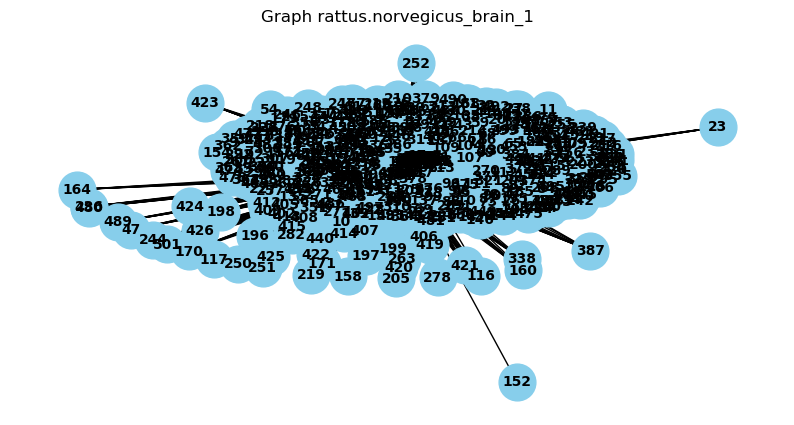

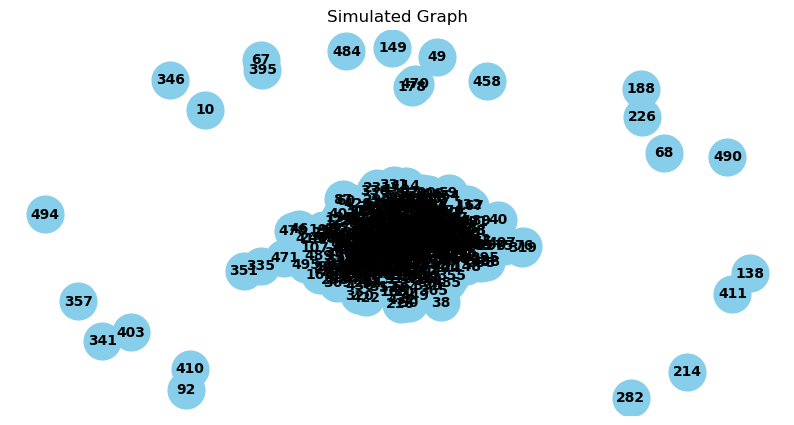

In [43]:
fig = ut.plot_graph_from_adjacency(g, pos=None, title='Graph ' + name, size=(10,5))
fig_est = ut.plot_graph_from_adjacency(g_est, pos=None, title = 'Simulated Graph', size=(10,5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


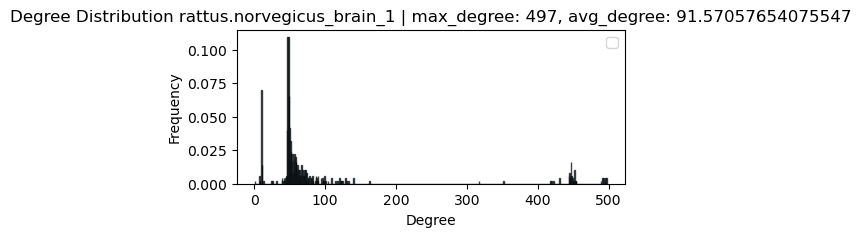

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


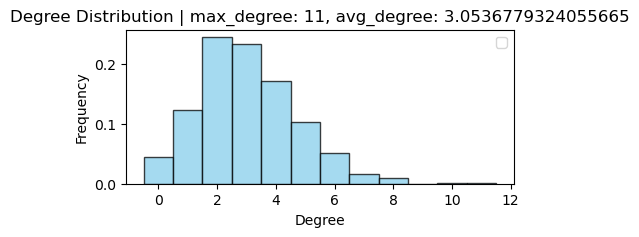

In [44]:
fig = ut.plot_degree_distribution(g, title='Degree Distribution '+name, size=(5,2))
fig_est = ut.plot_degree_distribution(g_est, title='Degree Distribution', size=(5,2))

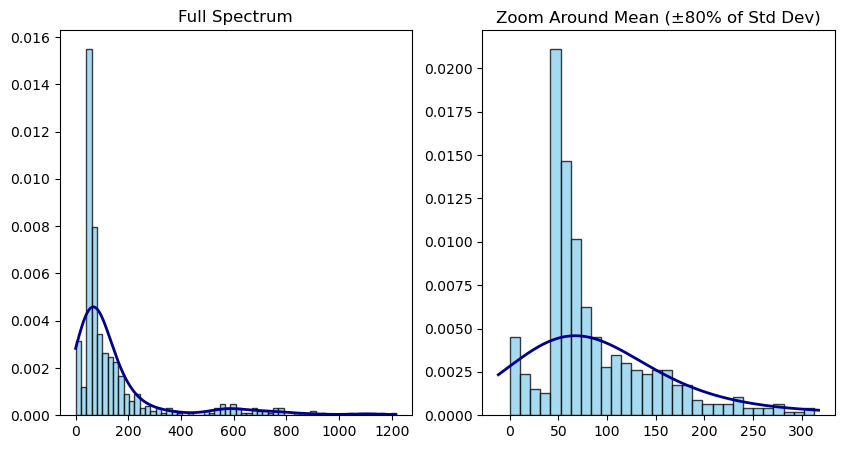

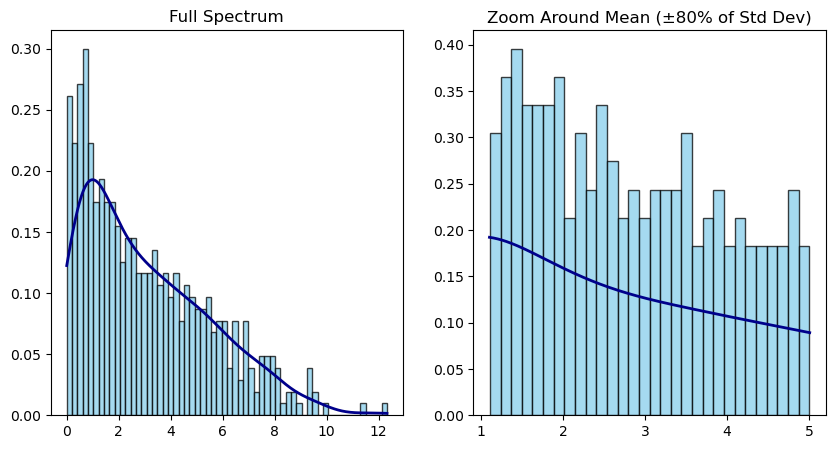

In [45]:
graph_model = GraphModel
s = graph_model.calculate_spectrum(g)
fig = ut.plot_spectrum_and_zoom(s, zoom_scale=0.8, size=(10,5))
fig_est = ut.plot_spectrum_and_zoom(s_est, zoom_scale=0.8, size=(10,5))

## Model selection

In [56]:
import src.model_selection as ms 
real_graph = nx.from_numpy_array(g)
logit_graph = nx.from_numpy_array(g_est)

selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f'for: {name}')
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


for: rattus.norvegicus_brain_1
The best model is: LG
Model scores:
ER: 0.7658749412180563
WS: -0.6257496359499564
BA: 0.6305935610164002
LG: -0.6735990310970768
